In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import lightgbm as lgb 
import xgboost as xgb 
import catboost as cbt 
import joblib 
import os 

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [2]:
# Specify the file path
train_dataset_path = r'E:\Trading Course\Kaggle\train.csv'
test_dataset_path = r'E:\Trading Course\Kaggle\example_test_files\test.csv'
revealed_targets_dataset_path = r'E:\Trading Course\Kaggle\example_test_files\revealed_targets.csv'
sample_submission_path = r'E:\Trading Course\Kaggle\example_test_files\sample_submission.csv'
    
train_dataset = pd.read_csv(train_dataset_path)
revealed_targets_dataset = pd.read_csv(revealed_targets_dataset_path)
test_dataset = pd.read_csv(test_dataset_path)
sample_submission_dataset = pd.read_csv(sample_submission_path)

In [20]:
train_dataset.head(10520)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_price,ask_size,wap,target,time_id,row_id,rsi,rsi_ma,percentK,percentD
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,1.000026,8493.03,1.0,-3.029704,0,0_0_0,NaN,NaN,NaN,NaN
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,1.000660,20605.09,1.0,-5.519986,0,0_0_1,NaN,NaN,NaN,NaN
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,...,1.000298,18995.00,1.0,-8.389950,0,0_0_2,NaN,NaN,NaN,NaN
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,1.000214,479032.40,1.0,-4.010200,0,0_0_3,NaN,NaN,NaN,NaN
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,1.000016,434.10,1.0,-7.349849,0,0_0_4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10515,10,1,0,1916576.41,1,0.999389,4996788.50,NaN,NaN,0.999177,...,1.000132,3017.44,1.0,-1.490116,55,1_0_10,NaN,NaN,NaN,NaN
10516,11,1,0,0.00,0,0.999669,1757776.21,NaN,NaN,0.999625,...,1.000624,23040.00,1.0,-2.840161,55,1_0_11,NaN,NaN,NaN,NaN
10517,12,1,0,3078462.90,-1,0.999924,28046564.88,NaN,NaN,0.999883,...,1.000088,9998.26,1.0,-3.439784,55,1_0_12,NaN,NaN,NaN,NaN
10518,13,1,0,12160587.22,1,1.000910,2300213.38,NaN,NaN,0.999963,...,1.001226,38052.00,1.0,-9.080172,55,1_0_13,NaN,NaN,NaN,NaN


In [4]:
def calculate_rsi_stochastic_oscillator(df, window_rsi=14, rsi_ma_window = 14, window_kd=14, smooth_d=3):
    # Group by date_id and calculate rolling values within each group
    grouped = df.groupby('date_id')
    
    # Calculate price changes
    df['delta'] = grouped['reference_price'].transform(lambda x: x.diff())
    
    # Separate gains (positive changes) and losses (negative changes)
    df['gains'] = df['delta'].where(df['delta'] > 0, 0)
    df['losses'] = -df['delta'].where(df['delta'] < 0, 0)

    # Calculate average gains and average losses over the specified window
    df['avg_gains'] = grouped['gains'].transform(lambda x: x.rolling(window=window_rsi, min_periods=1).mean())
    df['avg_losses'] = grouped['losses'].transform(lambda x: x.rolling(window=window_rsi, min_periods=1).mean())

    
    # Calculate relative strength (RS)
    df['rs'] = df['avg_gains'] / df['avg_losses']
    
    # Calculate the RSI index
    df['rsi'] = 100 - (100 / (1 + df['rs']))
    
    # Calculate the moving average of RSI
    df['rsi_ma'] = grouped['rsi'].transform(lambda x: x.rolling(window=rsi_ma_window, min_periods=1).mean())
    
    # Calculate Stochastic Oscillator (%K and %D) for a given stock.
    df['low_min'] = grouped['reference_price'].transform(lambda x: x.rolling(window=window_kd, min_periods=1).min())
    df['high_max'] = grouped['reference_price'].transform(lambda x: x.rolling(window=window_kd, min_periods=1).max())

    # Calculate %K
    df['percentK'] = ((df['reference_price'] - df['low_min']) / 
                        (df['high_max'] - df['low_min']) * 100)
    
    # Smooth %K to get %D common choices of smooth_d are 3 or 5. Default is 3
    df['percentD'] = grouped['percentK'].transform(lambda x: x.rolling(window=smooth_d, min_periods=1).max())
    
    #return rsi, rsi_ma, percentK, percentD
    #return df['rsi'], df['rsi_ma'], df['percentK'], df['percentD']

from concurrent.futures import ThreadPoolExecutor
import threading
from tqdm import tqdm

lock = threading.Lock()

def process_stock_date_pair(stock_id, train_dataset):
    stock_data = train_dataset[train_dataset['stock_id'] == stock_id].copy()
    calculate_rsi_stochastic_oscillator(stock_data, window_rsi=14, rsi_ma_window=14, window_kd=14, smooth_d=3)
    return stock_id, stock_data[['rsi', 'rsi_ma', 'percentK', 'percentD']]

def update_train_dataset(stock_id, result_data, train_dataset):
    with lock:
        mask = (train_dataset['stock_id'] == stock_id)
        train_dataset.loc[mask, ['rsi', 'rsi_ma', 'percentK', 'percentD']] = result_data.values

def parallelize_processing(unique_stock_ids, train_dataset):
    results = []

    with ThreadPoolExecutor() as executor:
        # Create a list of tuples containing unique_stock_ids
        combinations = [(stock_id, train_dataset) for stock_id in unique_stock_ids]

        # Use executor.map to get results in the order they were submitted
        results = list(tqdm(executor.map(lambda stock_id: process_stock_date_pair(stock_id, train_dataset), unique_stock_ids), total=len(unique_stock_ids)))

        print("Processing completed. Starting result update.")

        # Update train_dataset with the results
        list(tqdm(executor.map(lambda args: update_train_dataset(*args, train_dataset),
                               [(stock_id, result_data) for stock_id, result_data in results]),
                  total=len(results)))


# Get unique stock and date IDs
unique_stock_ids = train_dataset['stock_id'].unique()

# Parallelize the processing
parallelize_processing(unique_stock_ids, train_dataset)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:34<00:00,  1.30it/s]


Processing completed. Starting result update.


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.65it/s]


In [71]:
def generate_features(df):
    features = ['date_id','seconds_in_bucket', 'imbalance_buy_sell_flag', 'imbalance_size', 'matched_size', 'bid_size', 'ask_size', 
            'reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap', 'rsi', 'rsi_ma', 'percentK', 'percentD', 'imb_s1', 'imb_s2']
    
    df['imb_s1'] = df.eval('(bid_size-ask_size)/(bid_size+ask_size)')
    df['imb_s2'] = df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')
    
    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']
    
    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            if i>j:
                df[f'{a}_{b}_imb'] = df.eval(f'({a}-{b})/({a}+{b})')
                features.append(f'{a}_{b}_imb')    
                    
    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            for k,c in enumerate(prices):
                if i>j and j>k:
                    max_ = df[[a,b,c]].max(axis=1)
                    min_ = df[[a,b,c]].min(axis=1)
                    mid_ = df[[a,b,c]].sum(axis=1)-min_-max_

                    df[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_)
                    features.append(f'{a}_{b}_{c}_imb2')
                    
    # for sec_in bucket lower than 300, label it with 0. Otherwise label it with 1
    df['auction_stage'] = (df['seconds_in_bucket'] > 299).astype(int)
    features.append('auction_stage')  

    # rsi - rsi_ma
    df['rsi_rsi_ma_diff'] = df['rsi'] - df['rsi_ma']
    features.append('rsi_rsi_ma_diff')
    
    # for deleating nan values together
    features.append('target')
    
    return df[features]


TRAINING = True
if TRAINING:
#    df_train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
    df_ = generate_features(train_dataset)

In [44]:
df_.head()

,seconds_in_bucket,imbalance_buy_sell_flag,imbalance_size,matched_size,bid_size,ask_size,reference_price,far_price,near_price,ask_price,...,wap_near_price_reference_price_imb2,wap_near_price_far_price_imb2,wap_ask_price_reference_price_imb2,wap_ask_price_far_price_imb2,wap_ask_price_near_price_imb2,wap_bid_price_reference_price_imb2,wap_bid_price_far_price_imb2,wap_bid_price_near_price_imb2,wap_bid_price_ask_price_imb2,auction_stage
0,0,1,3180602.69,13380276.64,60651.50,8493.03,0.999812,NaN,NaN,1.000026,...,-1.000188,-1.0,0.138298,-1.000026,-1.000026,-1.693353e+12,-1.000188,-1.000188,0.138298,0
1,0,-1,166603.91,1642214.25,3233.04,20605.09,0.999896,NaN,NaN,1.000660,...,-1.000104,-1.0,6.346154,-1.000660,-1.000660,9.367487e+11,-1.000104,-1.000104,6.346154,0
2,0,-1,302879.87,1819368.03,37956.00,18995.00,0.999561,NaN,NaN,1.000298,...,-1.000439,-1.0,0.678815,-1.000298,-1.000298,2.778481e+00,-1.000597,-1.000597,0.499162,0
3,0,-1,11917682.27,18389745.62,2324.90,479032.40,1.000171,NaN,NaN,1.000214,...,-1.000171,-1.0,0.251462,-1.000214,-1.000214,1.710000e+02,-1.000001,-1.000001,214.000000,0
4,0,-1,447549.96,17860614.95,16485.54,434.10,0.999532,NaN,NaN,1.000016,...,-1.000468,-1.0,0.034188,-1.000016,-1.000016,3.391304e+00,-1.000606,-1.000606,0.026403,0


In [65]:
df_.isna().sum()

date_id                                            0
seconds_in_bucket                                  0
imbalance_buy_sell_flag                            0
imbalance_size                                   220
matched_size                                     220
bid_size                                           0
ask_size                                           0
reference_price                                  220
far_price                                    2894342
near_price                                   2857180
ask_price                                        220
bid_price                                        220
wap                                              220
rsi                                           155756
rsi_ma                                        133270
percentK                                      160322
percentD                                      151884
imb_s1                                            87
imb_s2                                        

In [38]:
# Check if NaN values in 'column1' are fully contained in NaN values of 'column2'
columnA = 'bid_price_near_price_far_price_imb2'
columnB = 'near_price_reference_price_imb'

is_contained = df_[columnA].isna().all() and df_[columnB].isna().any()

if is_contained:
    print("NaN values in 'columnA' are fully contained in NaN values of 'columnB'")
else:
    print("NaN values in 'columnA' are not fully contained in NaN values of 'columnB'")

# Count NaN values in each column
nan_count_A = df_[columnA].isna().sum()
nan_count_B = df_[columnB].isna().sum()

# Count NaN values in both columns
nan_overlap_count = df_[[columnA, columnB]].isna().all(axis=1).sum()

# Calculate the percentage of overlap
overlap_percentage = (nan_overlap_count / min(nan_count_A, nan_count_B)) * 100

print(f"nan_count_A is: {nan_count_A:.2f}, nan_count_B is: {nan_count_B:.2f}, Percentage of NaN overlap: {overlap_percentage:.2f}%")

NaN values in 'columnA' are not fully contained in NaN values of 'columnB'
nan_count_A is: 78486.00, nan_count_B is: 2857180.00, Percentage of NaN overlap: 0.28%


In [37]:
nan_rows = df_[df_['ask_price_near_price_reference_price_imb2'].isna()]
nan_rows

,seconds_in_bucket,imbalance_buy_sell_flag,imbalance_size,matched_size,bid_size,ask_size,reference_price,far_price,near_price,ask_price,...,wap_near_price_reference_price_imb2,wap_near_price_far_price_imb2,wap_ask_price_reference_price_imb2,wap_ask_price_far_price_imb2,wap_ask_price_near_price_imb2,wap_bid_price_reference_price_imb2,wap_bid_price_far_price_imb2,wap_bid_price_near_price_imb2,wap_bid_price_ask_price_imb2,auction_stage
5730,300,0,0.00,26670118.88,19319.31,16149.55,1.000241,1.000241,1.000241,1.000241,...,0.0,0.000000,0.0,0.000000,0.0,0.837607,0.837607,0.837607,0.837607,1
5753,300,0,0.00,50356232.67,52765.02,25455.12,1.001906,1.001906,1.001906,1.001906,...,0.0,0.000000,0.0,0.000000,0.0,0.479263,0.479263,0.479263,0.479263,1
5761,300,1,97826.26,2633922.09,146753.60,140472.51,0.998545,1.002108,0.998545,0.998545,...,0.0,8.190805,0.0,8.190805,0.0,0.953947,8.767544,0.953947,0.953947,1
5765,300,0,0.00,10179452.73,6166.92,12094.00,1.000007,1.000007,1.000007,1.000007,...,0.0,0.000000,0.0,0.000000,0.0,1.964286,1.964286,1.964286,1.964286,1
5772,300,0,0.00,3040807.71,18641.28,2667.24,0.998999,0.998999,0.998999,0.998999,...,0.0,0.000000,0.0,0.000000,0.0,0.143169,0.143169,0.143169,0.143169,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237915,540,0,0.00,6766657.74,174199.74,99286.56,1.000375,1.000375,1.000375,1.000375,...,0.0,0.000000,0.0,0.000000,0.0,0.567347,0.567347,0.567347,0.567347,1
5237923,540,1,17439.01,131336.62,546082.60,356560.60,1.000795,1.006898,1.000795,1.000795,...,0.0,2.541858,0.0,2.541858,0.0,0.648744,2.297757,0.648744,0.648744,1
5237934,540,0,0.00,17918802.47,171543.40,356547.39,1.000702,1.000702,1.000702,1.000702,...,0.0,0.000000,0.0,0.000000,0.0,2.081967,2.081967,2.081967,2.081967,1
5237941,540,1,115531.93,1925762.29,50606.27,291292.24,0.990809,0.992011,0.990809,0.990809,...,0.0,1.173828,0.0,1.173828,0.0,5.752809,12.505618,5.752809,5.752809,1


In [79]:
columns_to_fill_zero = ['far_price', 'near_price', 'far_price_reference_price_imb', 'near_price_reference_price_imb', 'near_price_far_price_imb', 'ask_price_far_price_imb', 'ask_price_near_price_imb', 'bid_price_far_price_imb', 'bid_price_near_price_imb', 'wap_far_price_imb', 'wap_near_price_imb']
df_.loc[:, columns_to_fill_zero] = df_.loc[:, columns_to_fill_zero].fillna(0)

df_ = df_.dropna(subset=['target'])
df_.isna().sum()

date_id                                           0
seconds_in_bucket                                 0
imbalance_buy_sell_flag                           0
imbalance_size                                  132
matched_size                                    132
bid_size                                          0
ask_size                                          0
reference_price                                 132
far_price                                         0
near_price                                        0
ask_price                                       132
bid_price                                       132
wap                                             132
rsi                                          155668
rsi_ma                                       133182
percentK                                     160234
percentD                                     151796
imb_s1                                            0
imb_s2                                          132
far_price_re

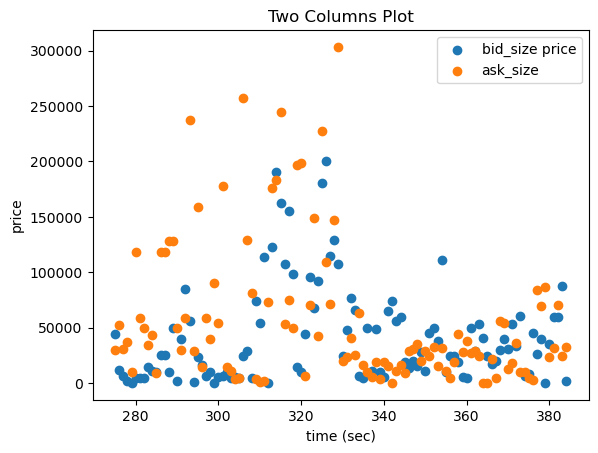

In [84]:
test_date_id = 7
test_stock_id = 0
mask = ((train_dataset['date_id'] > test_date_id-3) & (train_dataset['date_id'] < test_date_id))&(train_dataset['stock_id'] == test_stock_id)

# Plotting
plt.scatter(train_dataset[mask]['time_id'], train_dataset[mask]['bid_size'], label='bid_size price')
plt.scatter(train_dataset[mask]['time_id'], train_dataset[mask]['ask_size'], label='ask_size')

# Adding labels and title
plt.xlabel('time (sec)')
plt.ylabel('price')
plt.title('Two Columns Plot')

# Adding legend
plt.legend()

# Display the plot
plt.show()

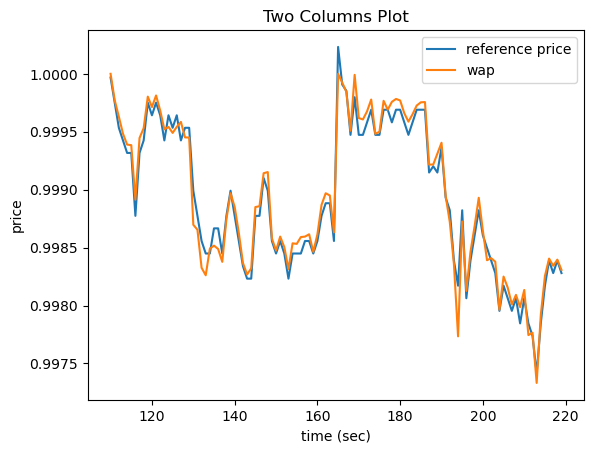

In [24]:
test_date_id = 4
test_stock_id = 0
mask = ((train_dataset['date_id'] > test_date_id-3) & (train_dataset['date_id'] < test_date_id))&(train_dataset['stock_id'] == test_stock_id)

# Plotting
plt.plot(train_dataset[mask]['time_id'], train_dataset[mask]['reference_price'], label='reference price')
plt.plot(train_dataset[mask]['time_id'], train_dataset[mask]['wap'], label='wap')

# Adding labels and title
plt.xlabel('time (sec)')
plt.ylabel('price')
plt.title('Two Columns Plot')

# Adding legend
plt.legend()

# Display the plot
plt.show()

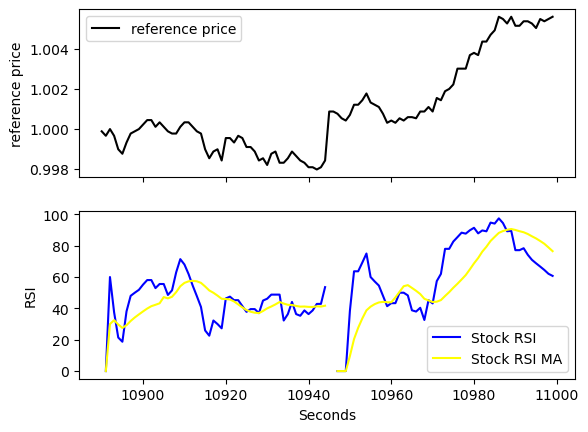

In [8]:
# Create a figure and two subplots with a shared X-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

test_date_id = 200
test_stock_id = 0

flag_date = (train_dataset['date_id'] > test_date_id-3) & (train_dataset['date_id'] < test_date_id)

# Plot data on the first subplot
ax1.plot(train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['time_id'], train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['reference_price'], label='reference price', color='black')
ax1.set_ylabel('reference price')
ax1.legend()

# Plot data on the second subplot
ax2.plot(train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['time_id'], train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['rsi'], label='Stock RSI', color='blue')
ax2.plot(train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['time_id'], train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['rsi_ma'], label='Stock RSI MA', color='yellow')
ax2.set_xlabel('Seconds')
ax2.set_ylabel('RSI')
ax2.legend()

# Show the plot
plt.show()

C:\Users\shiqi\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\shiqi\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


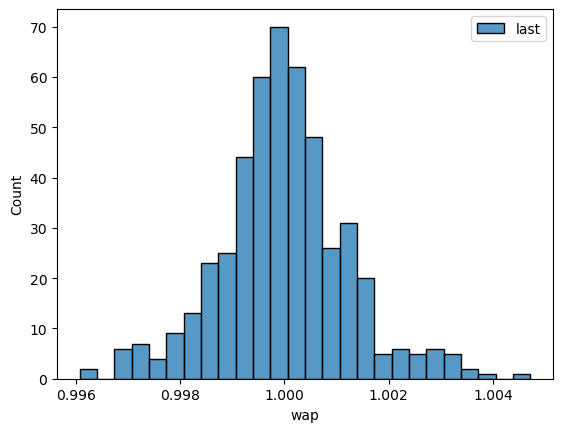

In [28]:
#sns.histplot(x=train_dataset.groupby('date_id').last().wap, label='last')
#sns.histplot(x=train_dataset.groupby('date_id').wap.max(), label='max')
#sns.histplot(x=train_dataset.groupby('date_id').wap.min(), label='min')
sns.histplot(x=train_dataset.groupby('date_id').wap.mean(), label='last')

plt.legend()


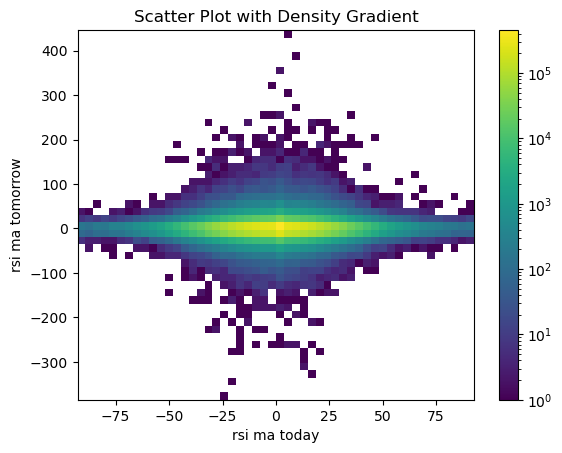

In [74]:
from matplotlib.colors import LogNorm
feature_hist = pd.DataFrame()

feature1 = 'rsi_rsi_ma_diff'
feature2 = 'target'
delay = 3

feature_hist[feature1] = train_dataset[feature1].copy()
feature_hist[feature2] = train_dataset[feature2].shift(delay).copy()
feature_hist = feature_hist.dropna()
some_mask = (feature_hist[feature1]>2)&(feature_hist[feature2]<98)

plt.hist2d(feature_hist[feature1], feature_hist[feature2], bins=(50, 50), cmap='viridis', norm=LogNorm())

#plt.hist2d(rsi_hist[some_mask][feature1], feature_hist[some_mask][feature2], bins=(50, 50), cmap='viridis')
#plt.scatter(train_dataset['rsi_ma'], train_dataset['rsi_ma'].shift(3), c=np.log1p(np.arange(len(train_dataset['rsi_ma']))), cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
#cbar.set_label('Density')
plt.xlabel('rsi ma today')
plt.ylabel('rsi ma tomorrow')
plt.title('Scatter Plot with Density Gradient')
plt.show()


In [ ]:
plt.scatter(average_wap, lagged_average_wap, c=np.log1p(np.arange(len(average_wap))), cmap='viridis', marker='o', alpha=0.5)


In [80]:
split_day = 435
OFFLINE = True
if OFFLINE:
    df_train = df_[df_["date_id"] <= split_day]
    df_valid = df_[df_["date_id"] > split_day]
    df_train_target = df_[df_["date_id"] <= split_day]['target']
    df_valid_target = df_[df_["date_id"] > split_day]['target']
    
    print("Offline mode")
    print(f"train : {df_train.shape}, valid : {df_valid.shape}")
else:
    df_train = df
    print("Online mode")

df_train = df_train.drop('date_id', axis=1)
df_valid = df_valid.drop('date_id', axis=1)


Offline mode
train : (4742893, 57), valid : (494999, 57)


In [72]:
df_train.head()

,seconds_in_bucket,imbalance_buy_sell_flag,imbalance_size,matched_size,bid_size,ask_size,reference_price,far_price,near_price,ask_price,...,wap_near_price_far_price_imb2,wap_ask_price_reference_price_imb2,wap_ask_price_far_price_imb2,wap_ask_price_near_price_imb2,wap_bid_price_reference_price_imb2,wap_bid_price_far_price_imb2,wap_bid_price_near_price_imb2,wap_bid_price_ask_price_imb2,auction_stage,rsi_rsi_ma_diff
0,0,1,3180602.69,13380276.64,60651.50,8493.03,0.999812,NaN,NaN,1.000026,...,-1.0,0.138298,-1.000026,-1.000026,-1.693353e+12,-1.000188,-1.000188,0.138298,0,NaN
1,0,-1,166603.91,1642214.25,3233.04,20605.09,0.999896,NaN,NaN,1.000660,...,-1.0,6.346154,-1.000660,-1.000660,9.367487e+11,-1.000104,-1.000104,6.346154,0,NaN
2,0,-1,302879.87,1819368.03,37956.00,18995.00,0.999561,NaN,NaN,1.000298,...,-1.0,0.678815,-1.000298,-1.000298,2.778481e+00,-1.000597,-1.000597,0.499162,0,NaN
3,0,-1,11917682.27,18389745.62,2324.90,479032.40,1.000171,NaN,NaN,1.000214,...,-1.0,0.251462,-1.000214,-1.000214,1.710000e+02,-1.000001,-1.000001,214.000000,0,NaN
4,0,-1,447549.96,17860614.95,16485.54,434.10,0.999532,NaN,NaN,1.000016,...,-1.0,0.034188,-1.000016,-1.000016,3.391304e+00,-1.000606,-1.000606,0.026403,0,NaN


In [ ]:
if TRAINING:
    feature_name = list(df_train.columns)
    lgb_params = {
        "objective" : "mae",
        "n_estimators" : 3000,
        "num_leaves" : 128,
        "subsample" : 0.6,
        "colsample_bytree" : 0.6,
        "learning_rate" : 0.05,
        "n_jobs" : 4,
        #"device" : "gpu",
        "verbosity": -1,
        "importance_type" : "gain",
    }

    print(f"Feature length = {len(feature_name)}")

    #offline_split = df_train['date_id']>(split_day - 45)
    #df_offline_train = df_train_feats[~offline_split]
    #df_offline_valid = df_train_feats[offline_split]
    #df_offline_train_target = df_train['target'][~offline_split]
    #df_offline_valid_target = df_train['target'][offline_split]

    df_offline_train = df_train
    df_offline_valid = df_valid
    df_offline_train_target = df_train_target
    df_offline_valid_target = df_valid_target

    print("Valid Model Trainning.")
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        df_offline_train[feature_name],
        df_offline_train_target,
        eval_set=[(df_offline_valid[feature_name], df_offline_valid_target)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
        ],
    )

    del df_offline_train, df_offline_valid, df_offline_train_target, df_offline_valid_target
    gc.collect()

    # infer
    df_train_target = df_train["target"]
    print("Infer Model Trainning.")
    infer_params = lgb_params.copy()
    infer_params["n_estimators"] = int(1.2 * lgb_model.best_iteration_)
    infer_lgb_model = lgb.LGBMRegressor(**infer_params)
    infer_lgb_model.fit(df_train_feats[feature_name], df_train_target)

    if OFFLINE:   
        # offline predictions
        df_valid_target = df_valid["target"]
        offline_predictions = infer_lgb_model.predict(df_valid_feats[feature_name])
        offline_score = mean_absolute_error(offline_predictions, df_valid_target)
        print(f"Offline Score {np.round(offline_score, 4)}")

Feature length = 56
Valid Model Trainning.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.9001
[200]	valid_0's l1: 0.248867
[300]	valid_0's l1: 0.156136
[400]	valid_0's l1: 0.149812
[500]	valid_0's l1: 0.146755
[600]	valid_0's l1: 0.144725
[700]	valid_0's l1: 0.143489
[800]	valid_0's l1: 0.142482
[900]	valid_0's l1: 0.141775
[1000]	valid_0's l1: 0.141133
[1100]	valid_0's l1: 0.140452
[1200]	valid_0's l1: 0.140029
[1300]	valid_0's l1: 0.139423
[1400]	valid_0's l1: 0.13893
[1500]	valid_0's l1: 0.138496
[1600]	valid_0's l1: 0.138292
[1700]	valid_0's l1: 0.138039
[1800]	valid_0's l1: 0.137738
[1900]	valid_0's l1: 0.137404
[2000]	valid_0's l1: 0.13716
[2100]	valid_0's l1: 0.136897
[2200]	valid_0's l1: 0.136722
[2300]	valid_0's l1: 0.136614
[2400]	valid_0's l1: 0.136515
[2500]	valid_0's l1: 0.136303


In [50]:
os.system('mkdir models')

#model_path ='/kaggle/input/optiverbaselinezyz'
model_path = r'E:\Trading Course\Kaggle\model'


N_fold = 5

if TRAINING:
    X = df_.values
    Y = train_dataset['target'].values

    X = X[np.isfinite(Y)]
    Y = Y[np.isfinite(Y)]

    index = np.arange(len(X))

models = []

def train(model_dict, modelname='lgb'):
    if TRAINING:
        model = model_dict[modelname]
        model.fit(X[index%N_fold!=i], Y[index%N_fold!=i], 
                    eval_set=[(X[index%N_fold==i], Y[index%N_fold==i])], 
                    verbose=10, 
                    early_stopping_rounds=100
                    )
        models.append(model)
        joblib.dump(model, './models/{modelname}_{i}.model')
    else:
        models.append(joblib.load(f'{model_path}/{modelname}_{i}.model'))
    return 

model_dict = {
    'lgb': lgb.LGBMRegressor(objective='regression_l1', n_estimators=500),
    'xgb': xgb.XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=500),
    'cbt': cbt.CatBoostRegressor(objective='MAE', iterations=3000),

}

for i in range(N_fold):
    train(model_dict, 'lgb')
    train(model_dict, 'xgb')
    train(model_dict, 'cbt')

TypeError: LGBMRegressor.fit() got an unexpected keyword argument 'verbose'

In [ ]:
((train_dataset['date_id'] == test_date_id)|(train_dataset['date_id'] == test_date_id))

In [56]:
lgb.LGBMRegressor(objective='regression_l1', n_estimators=500).get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'regression_l1',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [22]:
train_dataset['bid_ask_spread_crossing_return'] = (train_dataset['ask_price'] - train_dataset['bid_price'])/train_dataset['reference_price']

In [18]:
train_dataset['order_imbalance'] = (train_dataset['ask_size'] - train_dataset['bid_size'])/(train_dataset['bid_size']+train_dataset['ask_size'])

In [20]:
train_dataset = train_dataset.drop('bid_ask_spread_crossing_return', axis=1)

In [ ]:
# Select two columns for correlation
Column1 = 'order_imbalance'
Column2 = 'target'

sns.kdeplot(x=Column1, y=Column2, fill=True, cmap="Blues", data=train_dataset)
plt.title('Scatter Plot of Column1 vs Column2')
plt.xlabel('Column1')
plt.ylabel('Column2')
plt.show()

/home/shi/anaconda3/envs/tf_cpu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shi/anaconda3/envs/tf_cpu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shi/anaconda3/envs/tf_cpu/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shi/anaconda3/envs/tf_cpu/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

In [ ]:
def calculate_derivative(df):
    # Calculate price changes
    #delta = df[(df['stock_id'] == id)]['reference_price'].diff()
    delta = df['reference_price'].diff()
    
    # Separate gains (positive changes) and losses (negative changes)
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)

    # Calculate average gains and average losses over the specified window
    avg_gains = gains.rolling(window=window, min_periods=1).mean()
    avg_losses = losses.rolling(window=window, min_periods=1).mean()

    # Calculate relative strength (RS)
    rs = avg_gains / avg_losses

    # Calculate the RSI index
    rsi = 100 - (100 / (1 + rs))

    # Calculate the moving average of RSI
    rsi_ma = rsi.rolling(window=rsi_ma_window, min_periods=1).mean()

    return rsi, rsi_ma